# Building a House Price Predictor API  
The client is interested in forecasting houses so the company can look to invest. Rather than using a registered valuer they're looking for something which can be done using the latest technology. Jamie has collected some data on existing house prices over the last few years and has asked to see what you can do. 

# 1. Import Data

In [1]:
!pip install pandas scikit-learn xgboost dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 44.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 48.3 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.3/502.3 kB 9.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.2/37.2 MB 38.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 11.6 MB/s eta 0:00:00

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import pandas as pd

In [2]:
# read the data
df = pd.read_csv('./regressiondata.csv', index_col='ID')

In [3]:
# display the first 5 rows of data
df.head()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
0,2020.12,17.0,467.644775,4.0,5222.0,467104
1,2021.04,36.0,659.924963,3.0,5222.0,547714
2,2019.04,38.0,305.475941,7.0,5213.0,277232
3,2021.10,11.0,607.034754,5.0,5213.0,295958
4,2021.02,14.0,378.827222,5.0,5614.0,439963


# 2. Split Data to Prevent Snooping Bias

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
# split data into training and testing
train, test = train_test_split(df, test_size=0.3, random_state=1234)

In [6]:
type(train)

pandas.core.frame.DataFrame

In [7]:
#dimmensions of train and test
print(f' Rows and Columns in training set {train.shape}')

print(f' Rows and Columns in training set {test.shape}')

 Rows and Columns in training set (6549, 6)
 Rows and Columns in training set (2807, 6)


In [8]:
train.head()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
8450,2021.02,34.0,460.994365,8.0,5614.0,460286
5758,2020.01,17.0,614.851833,3.0,5213.0,253332
4030,2021.06,34.0,285.892687,9.0,5614.0,486532
8447,2020.12,0.0,195.213314,6.0,5222.0,595168
4370,2019.03,34.0,124.082230,8.0,5212.0,250495


In [9]:
test.head()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
7857,2021.11,0.0,267.000535,6.0,5222.0,919497
1641,2021.04,12.0,500.080510,5.0,5212.0,283680
3620,2019.07,14.0,4024.663391,0.0,5614.0,135818
2820,2020.09,18.0,568.954185,4.0,5614.0,468742
1572,2020.07,11.0,44.210016,1.0,5614.0,311065


# 3. Exploratory Data Analysis

## Bird's Eye View

In [10]:
# explore variable types
train.dtypes

TransactionDate      float64
HouseAge             float64
DistanceToStation    float64
NumberOfPubs         float64
PostCode             float64
HousePrice            object
dtype: object

In [11]:
train.iloc[0]['HousePrice']

'460286'

We need to make the following conversions:
- TransactionDate to date type
- Postcode to categorical type
- HousePrice is a string and need to be a numerical feature


In [12]:
#Get information about data
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6549 entries, 8450 to 8915
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TransactionDate    6548 non-null   float64
 1   HouseAge           6546 non-null   float64
 2   DistanceToStation  6547 non-null   float64
 3   NumberOfPubs       6547 non-null   float64
 4   PostCode           6547 non-null   float64
 5   HousePrice         6544 non-null   object 
dtypes: float64(5), object(1)
memory usage: 358.1+ KB


In [13]:
# Create summary statistics on numeric features
train.describe()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode
count,6548.000000,6546.000000,6547.000000,6.547000e+03,6547.000000
mean,2020.072389,17.375344,1091.759504,7.677828e+02,5294.499160
std,0.815922,11.469272,1270.038426,6.179430e+04,158.397718
min,2019.010000,0.000000,23.829424,0.000000e+00,5212.000000
25%,2019.100000,9.000000,268.649033,1.000000e+00,5213.000000
50%,2020.070000,15.000000,545.312168,4.000000e+00,5217.000000
75%,2021.040000,28.000000,1529.343484,6.000000e+00,5222.000000
max,2021.120000,43.000000,6486.256457,4.999999e+06,5614.000000


Max value of Number of Pubs makes no sense.  It says a house might have 4990000 pubs near it.  This might be a data error.

In [14]:
# Type cast incorrect datatypes to new datatypes
train['PostCode'] = train['PostCode'].astype(str)
train['TransactionDate'] = train['TransactionDate'].astype(str)

In [15]:
# HousePrice transformation
train['HousePrice'] = train['HousePrice'].astype(float)

ValueError: could not convert string to float: '??'

In [16]:
train.dtypes

TransactionDate       object
HouseAge             float64
DistanceToStation    float64
NumberOfPubs         float64
PostCode              object
HousePrice            object
dtype: object

In [17]:
# Create summary statistics for non-numeric features
train.describe(include='object')

,TransactionDate,PostCode,HousePrice
count,6549,6549,6544
unique,37,6,6496
top,2019.01,5212.0,290262
freq,212,1338,2


## Analyse Numerical Attributes

### Plot Distributions

In [46]:
#Install dependencies
!pip install matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 27.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.6/243.6 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 37.2 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [18]:
#Import data viz libs
from matplotlib import pyplot as plt
import seaborn as sns

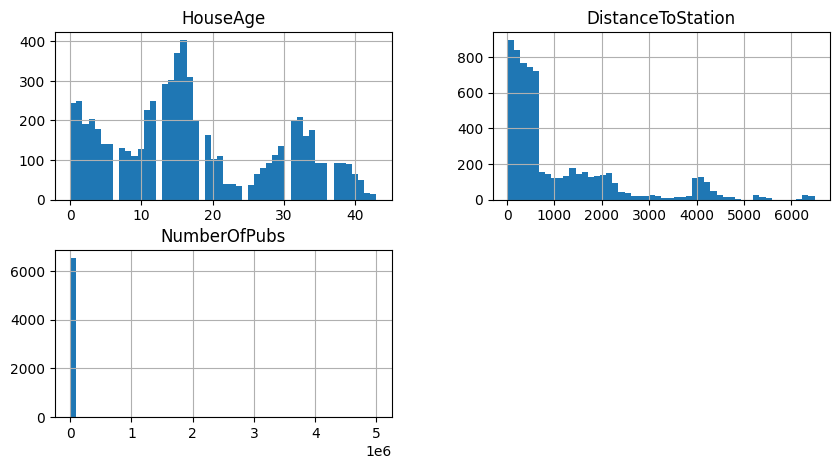

In [19]:
# Plot distributions training
train.hist(figsize=(10,5), bins=50)
plt.show()

### Why isn't House Price Showing up as Numeric?

In [ ]:
#str => float - giving an error
train['HousePrice'].astype(float)

In [21]:
#Filter data based on HousePrice == '??'
train[train['HousePrice'] == '??']

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
8718,2020.08,16.0,122.432508,5.0,5213.0,??


In [22]:
#Drop rows equal to '??'
train = train[train['HousePrice'] != '??']
train.shape

(6548, 6)

In [23]:
#Ovewrite Houseprice as float column
train['HousePrice'] = train['HousePrice'].astype(float)

In [24]:
train.dtypes

TransactionDate       object
HouseAge             float64
DistanceToStation    float64
NumberOfPubs         float64
PostCode              object
HousePrice           float64
dtype: object

In [25]:
train.describe()

,HouseAge,DistanceToStation,NumberOfPubs,HousePrice
count,6545.000000,6546.000000,6.546000e+03,6.543000e+03
mean,17.375554,1091.907583,7.678993e+02,3.301605e+05
std,11.470136,1270.078922,6.179902e+04,1.828316e+05
min,0.000000,23.829424,0.000000e+00,4.282500e+04
25%,9.000000,268.747393,1.000000e+00,2.233130e+05
50%,15.000000,545.423211,4.000000e+00,3.090300e+05
75%,28.000000,1529.871942,6.000000e+00,4.161505e+05
max,43.000000,6486.256457,4.999999e+06,8.989772e+06


### Drop Outlier 

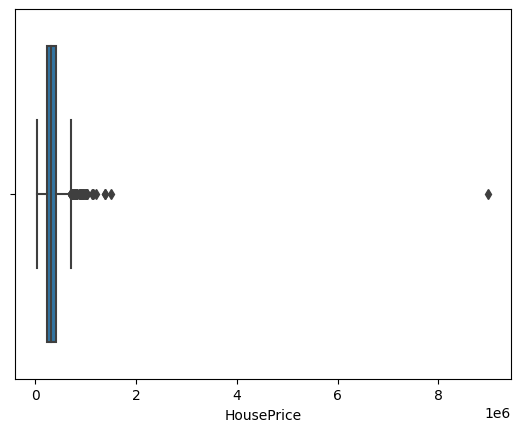

In [26]:
# Create box plot for house prices
sns.boxplot(x=train['HousePrice'])
plt.show()

In [27]:
# Find outlier
train.sort_values('HousePrice').tail(10)

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
9238,2019.11,10.0,169.424413,1.0,5222.0,1205920.0
149,2020.09,9.0,228.930655,1.0,5222.0,1374277.0
6066,2020.12,10.0,234.680008,1.0,5222.0,1374386.0
2749,2021.06,9.0,38.864337,1.0,5222.0,1504501.0
8445,2021.05,0.0,276.789752,9.0,5222.0,8989772.0
8103,2019.05,7.0,640.223538,10.0,5217.0,NaN
7673,nan,NaN,3830.892098,0.0,5217.0,NaN
32,2021.1,29.0,809.864711,8.0,5222.0,NaN
8112,2019.08,20.0,370.088151,NaN,nan,NaN


In [28]:
#drop that row 
train = train.drop(8445)

### What's happening with pubs

In [29]:
train.sort_values('NumberOfPubs').tail()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
422,2019.1,32.0,164.514773,10.0,5614.0,346126.0
5763,2020.02,33.0,326.339631,10.0,5222.0,555253.0
13,2019.05,8.0,273.264542,4999999.0,5213.0,356012.0
2416,2019.06,NaN,NaN,NaN,5222.0,268172.0
8112,2019.08,20.0,370.088151,NaN,nan,NaN


In [30]:
# Drop row with outlier on Number of Pubs
train.drop(13, inplace=True)

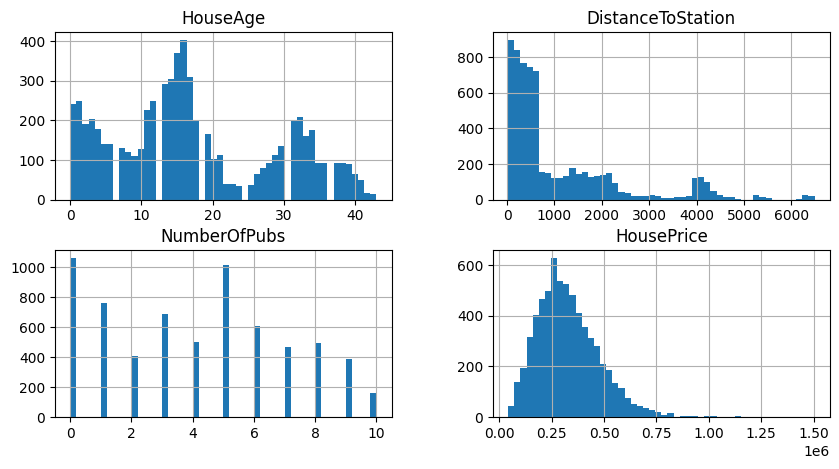

In [31]:
# Plot distributions training
train.hist(figsize=(10,5), bins=50)
plt.show()

## Analyse Categorical Variables

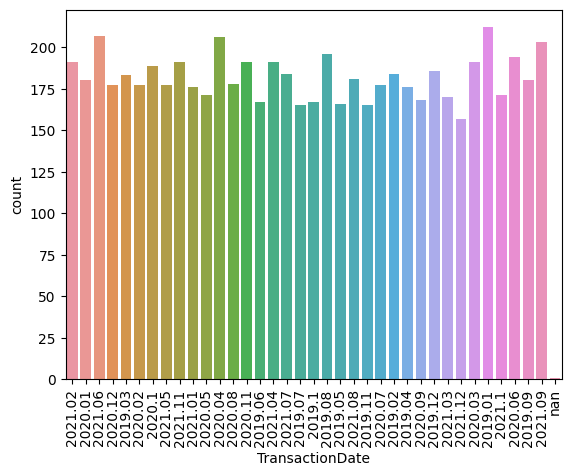

In [32]:
#Visualize Transaction date.  We will need to transform this to the right date type.
plt.xticks(rotation=90)
sns.countplot(x='TransactionDate', data=train)
plt.show()

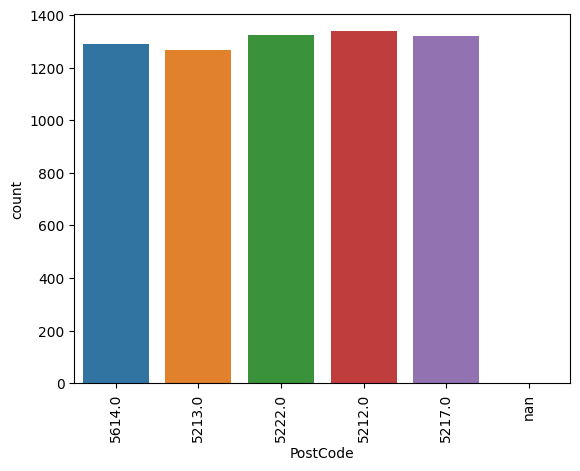

In [33]:
plt.xticks(rotation=90)
sns.countplot(x=train['PostCode'])
plt.show()

## Analyse Relationships Numeric/Numeric

### Calculate Pearson's Correlation

In [34]:
train.select_dtypes(exclude='object').corr()

,HouseAge,DistanceToStation,NumberOfPubs,HousePrice
HouseAge,1.000000,0.034074,0.044189,-0.156693
DistanceToStation,0.034074,1.000000,-0.586704,-0.539859
NumberOfPubs,0.044189,-0.586704,1.000000,0.452309
HousePrice,-0.156693,-0.539859,0.452309,1.000000


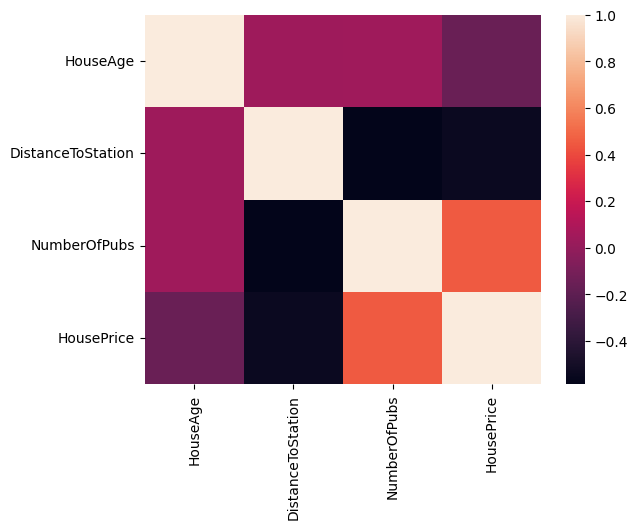

In [35]:
# Visualization of correlation using a heatmap
sns.heatmap(train.select_dtypes(exclude='object').corr())
plt.show()

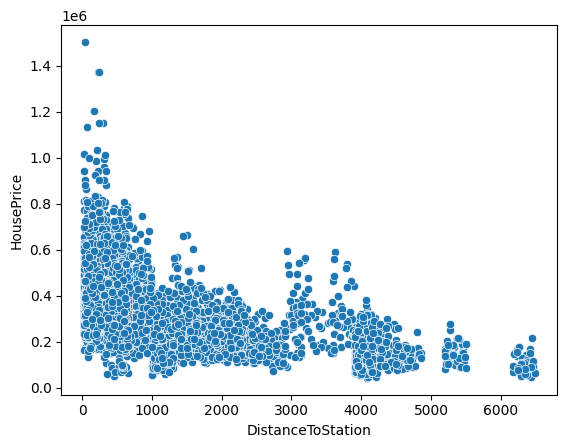

In [36]:
# Visualize a scatter plot
sns.scatterplot(x='DistanceToStation', y='HousePrice', data=train)
plt.show()

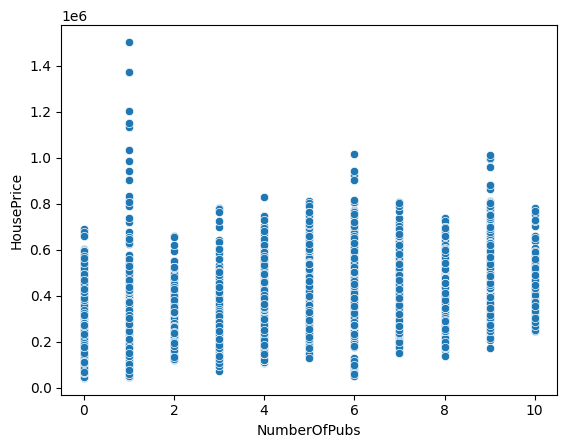

In [37]:
# Visualize a scatter plot
sns.scatterplot(x='NumberOfPubs', y='HousePrice', data=train)
plt.show()

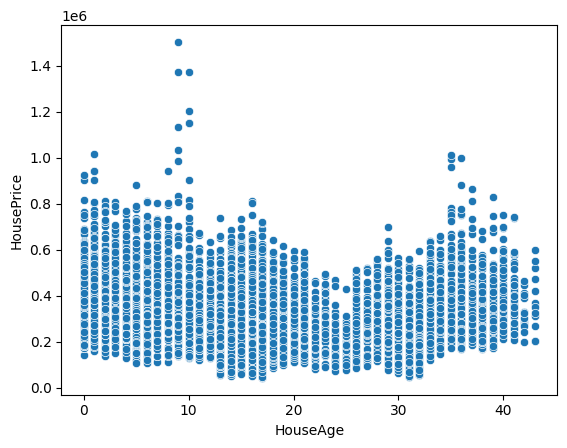

In [38]:
# Visualize a scatter plot
sns.scatterplot(x='HouseAge', y='HousePrice', data=train)
plt.show()

## Analyse Relationships Cat/Num

### Is Post Code Driving Value?

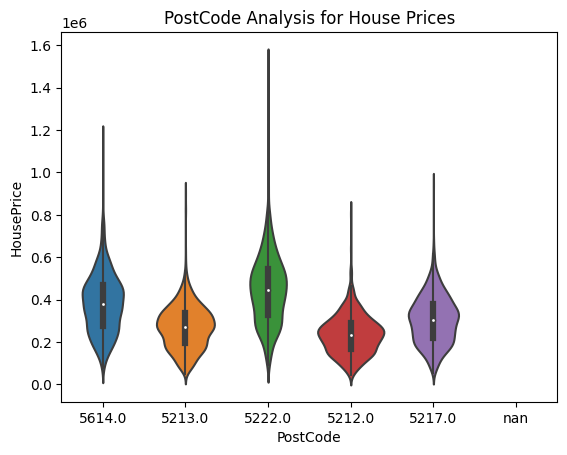

In [39]:
#Visualize PostCode
plt.title('PostCode Analysis for House Prices')
sns.violinplot(x='PostCode', y='HousePrice', data=train)
plt.show()

### What about the date it was sold?

In [40]:
#check for nulls in Date
train[train['TransactionDate'].isnull()]

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,


In [41]:
#check if string exists in a column
train[train['TransactionDate']=='nan']

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
7673,nan,NaN,3830.892098,0.0,5217.0,NaN


In [42]:
train.shape

(6546, 6)

In [43]:
#Drop missing house prices
#~ is opposite filter.  Apply the opposite of null values
train = train[(~train['HousePrice'].isnull())]

In [44]:
train.shape

(6541, 6)

In [45]:
train.iloc[0]

TransactionDate         2021.02
HouseAge                   34.0
DistanceToStation    460.994365
NumberOfPubs                8.0
PostCode                 5614.0
HousePrice             460286.0
Name: 8450, dtype: object

In [46]:
int(train.iloc[0]['TransactionDate'][:4])

2021

In [47]:
# Appply string transformation on Transaction Date
train['YearSold'] = train['TransactionDate'].apply(lambda x: x[:4]).astype(int)
train['MonthSold'] = train['TransactionDate'].apply(lambda x: x[5:]).astype(int)

In [48]:
train.dtypes

TransactionDate       object
HouseAge             float64
DistanceToStation    float64
NumberOfPubs         float64
PostCode              object
HousePrice           float64
YearSold               int64
MonthSold              int64
dtype: object

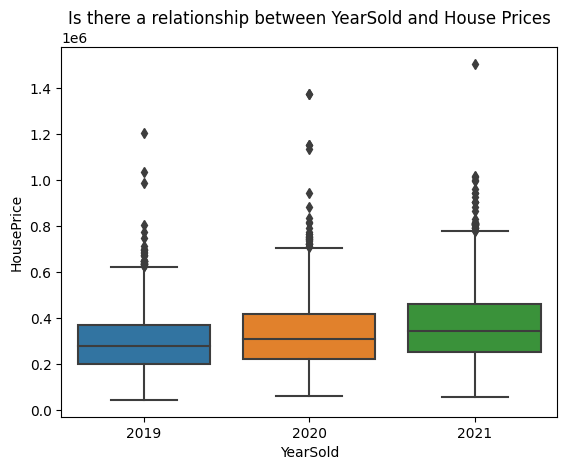

In [49]:
plt.title('Is there a relationship between YearSold and House Prices')
sns.boxplot(x='YearSold', y='HousePrice', data=train)
plt.show()

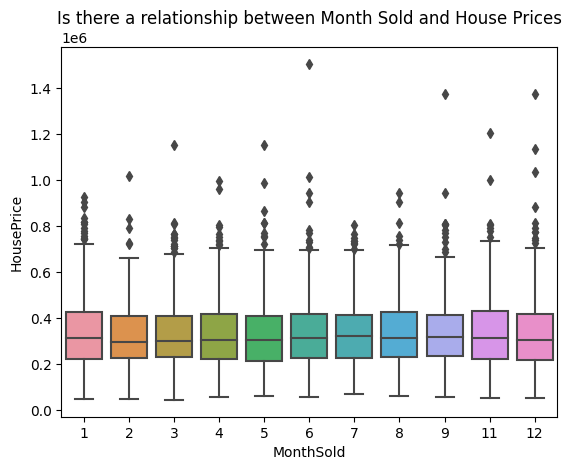

In [50]:
plt.title('Is there a relationship between Month Sold and House Prices')
sns.boxplot(x='MonthSold', y='HousePrice', data=train)
plt.show()

# 4. Data Preprocessing

## Build Preprocessing Function

In [51]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

In [52]:
# Test How imputer works on single rows
imputer = SimpleImputer()

In [53]:
imputer.fit(train[['HouseAge', 'DistanceToStation', 'NumberOfPubs']])

SimpleImputer()

In [54]:
imputer.transform(train[['HouseAge', 'DistanceToStation', 'NumberOfPubs']])

array([[3.40000000e+01, 4.60994365e+02, 8.00000000e+00],
       [1.70000000e+01, 6.14851833e+02, 3.00000000e+00],
       [3.40000000e+01, 2.85892687e+02, 9.00000000e+00],
       ...,
       [1.60000000e+01, 6.05834036e+02, 2.00000000e+00],
       [3.60000000e+01, 3.45823461e+01, 7.00000000e+00],
       [1.20000000e+01, 1.59998338e+03, 1.00000000e+00]])

In [55]:
#filter rows that have nan values on specific features
train[train['HouseAge'].isnull()][['HouseAge', 'DistanceToStation', 'NumberOfPubs']]

,HouseAge,DistanceToStation,NumberOfPubs
ID,,,
2416,NaN,NaN,NaN
24,NaN,NaN,4.0


In [56]:
# apply imputation of nan values on filtered rows that have nan values on specific features
imputer.transform(train[train['HouseAge'].isnull()][['HouseAge', 'DistanceToStation', 'NumberOfPubs']])

array([[  17.37972167, 1091.84711209,    4.0735474 ],
       [  17.37972167, 1091.84711209,    4.        ]])

In [197]:
# Standard Scalar

In [57]:
train['HouseAge'].mean()

17.379721669980118

In [58]:
train['HouseAge'].std()

11.471006657798647

In [59]:
(34 - train['HouseAge'].mean()) / train['HouseAge'].std()

1.4488944890220656

In [60]:
train['HouseAge']

ID
8450    34.0
5758    17.0
4030    34.0
8447     0.0
4370    34.0
        ... 
664     37.0
7540    34.0
7221    16.0
1318    36.0
8915    12.0
Name: HouseAge, Length: 6541, dtype: float64

In [61]:
# One hot encoder

In [62]:
onehot = OneHotEncoder()
onehot.fit(train[['PostCode']])

OneHotEncoder()

In [63]:
train['PostCode']

ID
8450    5614.0
5758    5213.0
4030    5614.0
8447    5222.0
4370    5212.0
         ...  
664     5217.0
7540    5212.0
7221    5217.0
1318    5217.0
8915    5614.0
Name: PostCode, Length: 6541, dtype: object

In [64]:
onehot.transform(train[['PostCode']]).toarray()

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [65]:
onehot.get_feature_names_out()

array(['PostCode_5212.0', 'PostCode_5213.0', 'PostCode_5217.0',
       'PostCode_5222.0', 'PostCode_5614.0'], dtype=object)

### Now, let's apply these logics for data preprocessing on our class

In [66]:
class Preprocessor(BaseEstimator, TransformerMixin):
    # Train our custom preprocessors
    def fit(self, X, y=None):
        
        # Create and fit simple imputer
        self.imputer = SimpleImputer()
        self.imputer.fit(X[['HouseAge', 'DistanceToStation', 'NumberOfPubs']])
        
        # Create and fit Standard Scaler
        self.scaler = StandardScaler()
        self.scaler.fit(X[['HouseAge', 'DistanceToStation', 'NumberOfPubs']])
        
        # Create One Hot Encoder
        self.onehot = OneHotEncoder(handle_unknown='ignore') #ignore any new values during scoring on postcode
        self.onehot.fit(X[['PostCode']])
        
        return self
    
    # Apply our custom preprocessors
    def transform(self, X):
        
        # Apply simple imputer and encoder
        imputed_cols = self.imputer.transform(X[['HouseAge', 'DistanceToStation', 'NumberOfPubs']])
        onehot_cols = self.onehot.transform(X[['PostCode']])
        
        # Copy the df
        transformed_df = X.copy()
        
        # Apply year and month transforms
        transformed_df['Year'] = transformed_df['TransactionDate'].apply(lambda x: x[:4]).astype(int)
        transformed_df['Month'] = transformed_df["TransactionDate"].apply(lambda x: x[5:]).astype(int)
        transformed_df = transformed_df.drop('TransactionDate', axis=1)
        
        #Apply transformed columns with imputation
        transformed_df[['HouseAge', 'DistanceToStation', 'NumberOfPubs']] = imputed_cols
        #Appy Standard Scaler 
        transformed_df[['HouseAge', 'DistanceToStation', 'NumberOfPubs']] = self.scaler.transform(transformed_df[['HouseAge', 'DistanceToStation', 'NumberOfPubs']])
        # Drop existing PostCode colum and replace with one hot equivalent 
        transformed_df = transformed_df.drop('PostCode', axis=1)
        transformed_df[self.onehot.get_feature_names_out()] = onehot_cols.toarray().astype(int)
        
        return transformed_df
    

In [208]:
# Test class

In [67]:
preproc = Preprocessor()

In [68]:
preproc.fit(train)

Preprocessor()

## Preview Preprocessed Data

In [69]:
preprocessed_df = preproc.transform(train.drop(['YearSold', "MonthSold"], axis=1))
preprocessed_df.head()

,HouseAge,DistanceToStation,NumberOfPubs,HousePrice,Year,Month,PostCode_5212.0,PostCode_5213.0,PostCode_5217.0,PostCode_5222.0,PostCode_5614.0
ID,,,,,,,,,,,
8450,1.449005,-0.496716,1.328375,460286.0,2021,2,0,0,0,0,1
5758,-0.033105,-0.375573,-0.363196,253332.0,2020,1,0,1,0,0,0
4030,1.449005,-0.634586,1.666689,486532.0,2021,6,0,0,0,0,1
8447,-1.515216,-0.705984,0.651746,595168.0,2020,12,0,0,0,1,0
4370,1.449005,-0.761991,1.328375,250495.0,2019,3,1,0,0,0,0


In [70]:
preprocessed_df.dtypes

HouseAge             float64
DistanceToStation    float64
NumberOfPubs         float64
HousePrice           float64
Year                   int64
Month                  int64
PostCode_5212.0        int64
PostCode_5213.0        int64
PostCode_5217.0        int64
PostCode_5222.0        int64
PostCode_5614.0        int64
dtype: object

In [71]:
preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6541 entries, 8450 to 8915
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   HouseAge           6541 non-null   float64
 1   DistanceToStation  6541 non-null   float64
 2   NumberOfPubs       6541 non-null   float64
 3   HousePrice         6541 non-null   float64
 4   Year               6541 non-null   int64  
 5   Month              6541 non-null   int64  
 6   PostCode_5212.0    6541 non-null   int64  
 7   PostCode_5213.0    6541 non-null   int64  
 8   PostCode_5217.0    6541 non-null   int64  
 9   PostCode_5222.0    6541 non-null   int64  
 10  PostCode_5614.0    6541 non-null   int64  
dtypes: float64(4), int64(7)
memory usage: 613.2 KB


## Clean up Analysis Features

In [72]:
train = train.drop(['YearSold', 'MonthSold'], axis=1)

In [73]:
train.head()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
8450,2021.02,34.0,460.994365,8.0,5614.0,460286.0
5758,2020.01,17.0,614.851833,3.0,5213.0,253332.0
4030,2021.06,34.0,285.892687,9.0,5614.0,486532.0
8447,2020.12,0.0,195.213314,6.0,5222.0,595168.0
4370,2019.03,34.0,124.082230,8.0,5212.0,250495.0


## Create X and y values

In [74]:
X_train = train.drop('HousePrice', axis=1)
y_train = train["HousePrice"]

# 5. Modelling

## Import ML Dependencies

In [75]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor

### Training Outside of a Pipeline

In [76]:
# Here is how you train outside of a pipeline 
X_temp = preprocessed_df.drop('HousePrice', axis=1)
Y_temp = preprocessed_df['HousePrice']

In [77]:
ridgemodel = Ridge()

In [78]:
ridgemodel.fit(X_temp, Y_temp)

Ridge()

In [79]:
ridgemodel.predict(X_temp)

array([453158.70403588, 281048.56313422, 473919.1346858 , ...,
       305550.331     , 349468.79290658, 301856.67576402])

## Create Pipelines

### Now let's do this with pipeline to get it ready for production
This makes things faster and more efficient

In [80]:
pipelines = {
    'ridge' : make_pipeline(Preprocessor(), Ridge()),
    'rf' : make_pipeline(Preprocessor(), RandomForestRegressor()),
    'gb' : make_pipeline(Preprocessor(), GradientBoostingRegressor()),
    'xg' : make_pipeline(Preprocessor(), XGBRegressor())
}


In [81]:
pipelines['xg']

Pipeline(steps=[('preprocessor', Preprocessor()),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

## Create Tuning Grids

In [82]:
pipelines['xg'].get_params()

{'memory': None,
 'steps': [('preprocessor', Preprocessor()),
  ('xgbregressor',
   XGBRegressor(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                predictor=None, random_state=None, ...))],
 'verbose': False,
 'preprocessor': Preprocessor(),
 'xgbregressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
             

In [83]:
grid = {
    'ridge': {'ridge__alpha':[0.05, 0.25, 0.5, 1.0]},
    'rf': {
        'randomforestregressor__n_estimators':[100, 200, 300], 
        'randomforestregressor__max_depth':[5, 6, 7, None]},
    'gb': {
        'gradientboostingregressor__n_estimators':[100, 200, 300], 
           'gradientboostingregressor__max_depth':[5, 6, 7, None]},
    'xg': {
        'xgbregressor__n_estimators':[100, 200, 300], 
        'xgbregressor__max_depth':[5, 6, 7, None]}
}

## Train Models and Perform HPO

In [84]:
from sklearn.model_selection import GridSearchCV

In [85]:
fit_models = {}

for algo, pipeline in pipelines.items():
    try:
        print(algo)
        model = GridSearchCV(pipeline, grid[algo], n_jobs=-1, cv=10, scoring='r2')
        model.fit(X_train, y_train)
        fit_models[algo]= model
    except Exception as e:
        print(f'Model {algo} had an error {e}')

ridge
rf
gb
xg


In [86]:
fit_models

{'ridge': GridSearchCV(cv=10,
              estimator=Pipeline(steps=[('preprocessor', Preprocessor()),
                                        ('ridge', Ridge())]),
              n_jobs=-1, param_grid={'ridge__alpha': [0.05, 0.25, 0.5, 1.0]},
              scoring='r2'),
 'rf': GridSearchCV(cv=10,
              estimator=Pipeline(steps=[('preprocessor', Preprocessor()),
                                        ('randomforestregressor',
                                         RandomForestRegressor())]),
              n_jobs=-1,
              param_grid={'randomforestregressor__max_depth': [5, 6, 7, None],
                          'randomforestregressor__n_estimators': [100, 200,
                                                                  300]},
              scoring='r2'),
 'gb': GridSearchCV(cv=10,
              estimator=Pipeline(steps=[('preprocessor', Preprocessor()),
                                        ('gradientboostingregressor',
                                      

# 6. Evaluate Models

## Import Evaluation Metrics

In [87]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

## Preprocess Test Set For Predictions

### Look for Nulls

In [88]:
# Look for nulls in dataset
test.isnull().sum()

TransactionDate      1
HouseAge             1
DistanceToStation    0
NumberOfPubs         0
PostCode             0
HousePrice           2
dtype: int64

In [89]:
# See rows with null values on House Price
test[test.HousePrice.isnull()]

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
48,NaN,13.0,1214.171333,1.0,5614.0,NaN
8106,2020.04,12.0,62.680175,7.0,5217.0,NaN


In [90]:
# Drop any nulls in the House Price
test = test[~test.HousePrice.isnull()]

In [91]:
# Check results of deleting null values
test.isnull().sum()

TransactionDate      0
HouseAge             1
DistanceToStation    0
NumberOfPubs         0
PostCode             0
HousePrice           0
dtype: int64

### Check datatypes

In [92]:
test.dtypes

TransactionDate      float64
HouseAge             float64
DistanceToStation    float64
NumberOfPubs         float64
PostCode             float64
HousePrice            object
dtype: object

In [93]:
train.dtypes

TransactionDate       object
HouseAge             float64
DistanceToStation    float64
NumberOfPubs         float64
PostCode              object
HousePrice           float64
dtype: object

In [94]:
test = test[test['HousePrice']!='??']
test['HousePrice'] = test.HousePrice.astype(float)
test['TransactionDate'] = test.TransactionDate.astype(str)
test['PostCode'] = test.PostCode.astype(str)
                                               

In [95]:
test.dtypes

TransactionDate       object
HouseAge             float64
DistanceToStation    float64
NumberOfPubs         float64
PostCode              object
HousePrice           float64
dtype: object

### Create X_test and y_test 

In [96]:
X_test = test.drop('HousePrice', axis=1)
y_test = test['HousePrice']

In [97]:
X_test.head()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode
ID,,,,,
7857,2021.11,0.0,267.000535,6.0,5222.0
1641,2021.04,12.0,500.080510,5.0,5212.0
3620,2019.07,14.0,4024.663391,0.0,5614.0
2820,2020.09,18.0,568.954185,4.0,5614.0
1572,2020.07,11.0,44.210016,1.0,5614.0


In [98]:
y_test.head()

ID
7857    919497.0
1641    283680.0
3620    135818.0
2820    468742.0
1572    311065.0
Name: HousePrice, dtype: float64

In [99]:
print(X_test.shape)
print(y_test.shape)

(2803, 5)
(2803,)


## Calculate Regression Metrics

In [100]:
for algo, model in fit_models.items():
    yhat = model.predict(X_test)
    r2 = r2_score(y_test, yhat)
    mae = mean_absolute_error(y_test, yhat)
    print(f'{algo}- R2 Score: {r2}, MAE Score: {mae}')

ridge- R2 Score: 0.6691443155811749, MAE Score: 62578.087797397166
rf- R2 Score: 0.8214993808447784, MAE Score: 44451.78706029254
gb- R2 Score: 0.8629449483190033, MAE Score: 38719.845225488105
xg- R2 Score: 0.853617617693814, MAE Score: 39618.537530937836


## Make Predictions

In [101]:
model = fit_models['gb']

In [102]:
yhat = model.predict(X_test)

In [103]:
results_df = y_test.to_frame()
results_df['yhat'] = yhat
results_df['delta'] = results_df.HousePrice.astype(float) - results_df.yhat

In [104]:
results_df

,HousePrice,yhat,delta
ID,,,
7857,919497.0,660072.297268,259424.702732
1641,283680.0,289177.792976,-5497.792976
3620,135818.0,166619.494653,-30801.494653
2820,468742.0,398384.284510,70357.715490
1572,311065.0,389518.489960,-78453.489960
...,...,...,...
435,234950.0,312868.879993,-77918.879993
3452,467844.0,464408.266592,3435.733408
2127,502553.0,392935.059367,109617.940633


In [263]:
results_df.to_csv('results.csv')

## Explain model

### Calculate Feature Importance

In [105]:
ensemble = model.best_estimator_['gradientboostingregressor']

In [106]:
ensemble

GradientBoostingRegressor(max_depth=5, n_estimators=300)

In [107]:
model.best_estimator_['gradientboostingregressor'].feature_importances_

array([0.1274718 , 0.46760169, 0.04500633, 0.05182666, 0.00619813,
       0.02391927, 0.00649077, 0.00969387, 0.17483796, 0.08695351])

In [108]:
sum(model.best_estimator_['gradientboostingregressor'].feature_importances_)

1.0

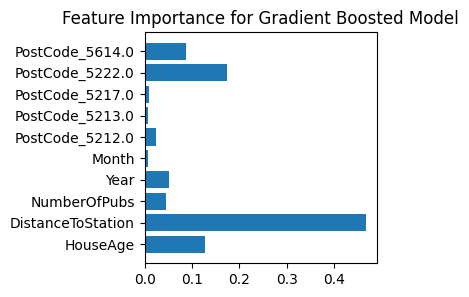

In [109]:
plt.figure(figsize=(3,3))
plt.title('Feature Importance for Gradient Boosted Model')
plt.barh(ensemble.feature_names_in_, ensemble.feature_importances_)
plt.show()

### Calculate Feature Importance for All Models

In [110]:
import numpy as np

In [111]:
fit_models['ridge'].best_estimator_[1].coef_

array([-23501.08564753, -58423.30626318,  32278.41514601,  36002.44335309,
          446.33873118, -86960.86709452, -56336.5860592 , -23824.63284292,
       114644.91033947,  52477.17565687])

In [112]:
np.square(fit_models['ridge'].best_estimator_[1].coef_)

array([5.52301027e+08, 3.41328271e+09, 1.04189608e+09, 1.29617593e+09,
       1.99218263e+05, 7.56219241e+09, 3.17381093e+09, 5.67613130e+08,
       1.31434555e+10, 2.75385396e+09])

In [113]:
np.square(fit_models['ridge'].best_estimator_[1].coef_)/np.sum(np.square(fit_models['ridge'].best_estimator_[1].coef_))

array([1.64842453e-02, 1.01874497e-01, 3.10969377e-02, 3.86862977e-02,
       5.94596526e-06, 2.25704876e-01, 9.47271060e-02, 1.69412578e-02,
       3.92285970e-01, 8.21928660e-02])

In [114]:
new_metric = np.sum(np.square(fit_models['ridge'].best_estimator_[1].coef_)/np.sum(np.square(fit_models['ridge'].best_estimator_[1].coef_)))

In [115]:
new_metric

1.0

In [116]:
feature_importances = {}

for algo, pipeline in fit_models.items():
    if algo == 'ridge': # calculate alternate metric
        coef_ = pipeline.best_estimator_[1].coef_
        feature_importances[algo] = np.square(coef_) / np.sum(np.square(coef_))
    else:
        feature_importances[algo] = pipeline.best_estimator_[1].feature_importances_
        

In [117]:
feature_importances

{'ridge': array([1.64842453e-02, 1.01874497e-01, 3.10969377e-02, 3.86862977e-02,
        5.94596526e-06, 2.25704876e-01, 9.47271060e-02, 1.69412578e-02,
        3.92285970e-01, 8.21928660e-02]),
 'rf': array([0.13623911, 0.44563118, 0.05599037, 0.05158816, 0.03431649,
        0.00879964, 0.00286679, 0.01187183, 0.1665828 , 0.08611362]),
 'gb': array([0.1274718 , 0.46760169, 0.04500633, 0.05182666, 0.00619813,
        0.02391927, 0.00649077, 0.00969387, 0.17483796, 0.08695351]),
 'xg': array([0.03207528, 0.07127062, 0.02292063, 0.05411822, 0.00475283,
        0.09275293, 0.02268689, 0.04478648, 0.41193107, 0.24270506],
       dtype=float32)}

In [118]:
importance_df = pd.DataFrame(feature_importances, index= ensemble.feature_names_in_)
importance_df

,ridge,rf,gb,xg
HouseAge,0.016484,0.136239,0.127472,0.032075
DistanceToStation,0.101874,0.445631,0.467602,0.071271
NumberOfPubs,0.031097,0.055990,0.045006,0.022921
Year,0.038686,0.051588,0.051827,0.054118
Month,0.000006,0.034316,0.006198,0.004753
PostCode_5212.0,0.225705,0.008800,0.023919,0.092753
PostCode_5213.0,0.094727,0.002867,0.006491,0.022687
PostCode_5217.0,0.016941,0.011872,0.009694,0.044786
PostCode_5222.0,0.392286,0.166583,0.174838,0.411931
PostCode_5614.0,0.082193,0.086114,0.086954,0.242705


### Plot Trees

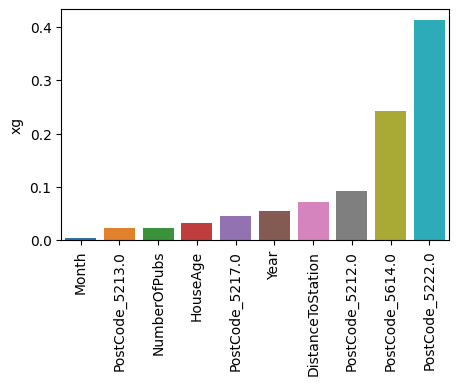

In [119]:
plt.figure(figsize=(5,3))
model_name = 'xg'
sorted_imp = importance_df.sort_values(model_name)
sns.barplot(x = sorted_imp.index, y= model_name, data = sorted_imp)
plt.xticks(rotation=90)
plt.show()

In [299]:
! pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 1.2 MB/s eta 0:00:00

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [120]:
from sklearn.tree import plot_tree
import xgboost as xgb
from matplotlib.pylab import rcParams

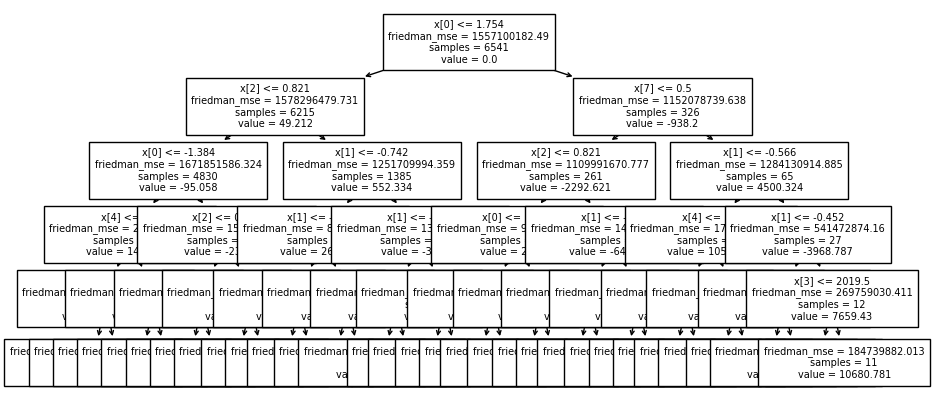

In [121]:
# Plot tree for gradient boosted model
plt.figure(figsize=(10,5))
plot_tree(ensemble.estimators_[299,0], fontsize= 7)
plt.show()

In [122]:
ensemble.feature_names_in_[2]

'NumberOfPubs'

In [123]:
X_train.shape

(6541, 5)

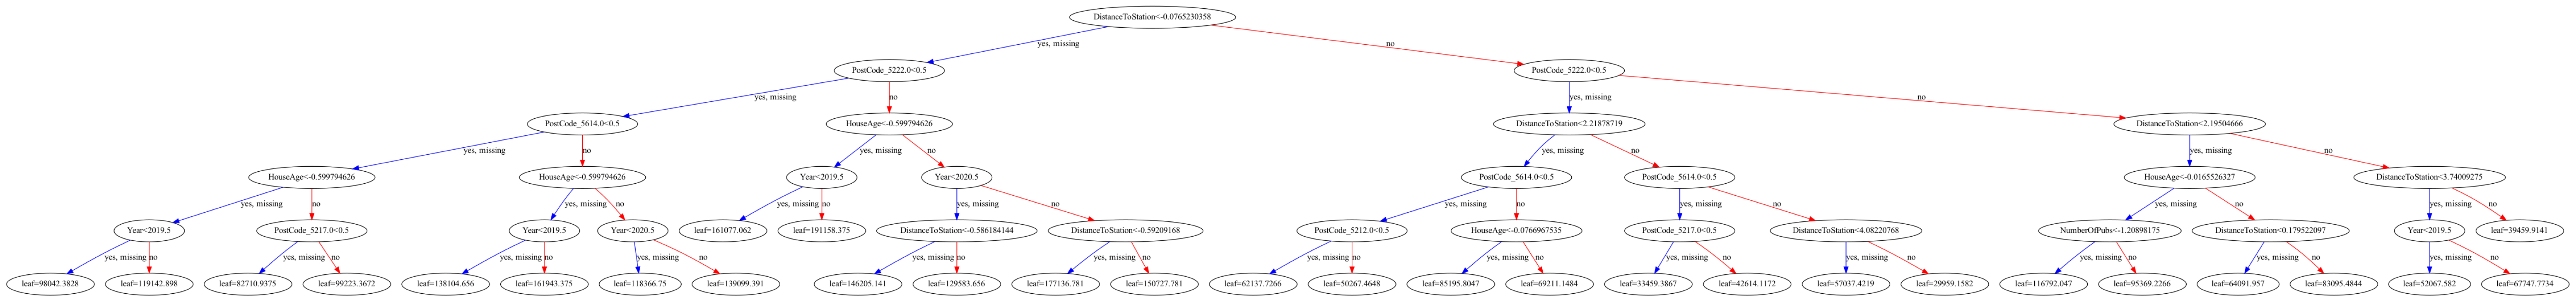

In [125]:
# Plot tree for gradient boosted model
rcParams['figure.figsize'] = 80,100
xgb.plot_tree(fit_models['xg'].best_estimator_[1])
plt.show()

# 7. Save model

In [126]:
import dill

In [127]:
model = fit_models['gb']

In [128]:
#Save model using dill\
with open('gb.pkl', 'wb') as f:  #wb = write binary
    dill.dump(model, f)

In [129]:
with open('gb.pkl', 'rb') as f:  #rb = read binary
    reloaded_model = dill.load(f)

In [130]:
reloaded_model

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor', Preprocessor()),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid={'gradientboostingregressor__max_depth': [5, 6, 7,
                                                                  None],
                         'gradientboostingregressor__n_estimators': [100, 200,
                                                                     300]},
             scoring='r2')

In [131]:
reloaded_model.predict(X_test)

array([660072.29726806, 289177.79297644, 166619.49465334, ...,
       392935.05936691, 737461.9967578 , 409655.04780016])

In [133]:
X_test.loc[0]

TransactionDate         2020.12
HouseAge                   17.0
DistanceToStation    467.644775
NumberOfPubs                4.0
PostCode                 5222.0
Name: 0, dtype: object

In [132]:
X_test.loc[0].to_json()

'{"TransactionDate":"2020.12","HouseAge":17.0,"DistanceToStation":467.6447748,"NumberOfPubs":4.0,"PostCode":"5222.0"}'